In [1]:
from __future__ import generators, division, absolute_import, with_statement, print_function, unicode_literals


import tensorflow as tf
import numpy as np

import glob


from sklearn.model_selection import train_test_split
from sklearn import preprocessing


import cv2
import tflearn

from tensorflow.contrib.layers import flatten
import tensorflow.contrib.layers as initializers
import tensorflow.contrib.slim as slim

import os

import matplotlib.pyplot as plt

from loss_functions import max_margin_hinge_loss, contrasive_loss

%matplotlib inline


In [2]:

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
data_path = 'data/ms-celeb/'

X = tf.placeholder(tf.float32, shape=(None, 64,64,1), name= 'input')
Y = tf.placeholder(tf.float32, shape=(None, 2), name = 'labels')

global_step = tf.Variable(0, trainable = False, name='global_step')

#batch_size = 32
#num_epochs = 10001

noClasses = 13

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction= 0.9)



In [10]:
def get_data():

    """
    Author:  Kamran Janjua (https://github.com/kjanjua26/Sound_Classification_Spectrograms/blob/master/GunShot/train.py)
    
    Function that loads data, normalizes the data, ceates a mapping file, and also serializes
    the dataset for later use
    
    Return:
    
    Dataset divided into x_train, y_train, x_test, y_test
    
    """
    mapping_file = open('mapping_file_res_urban.txt', 'w+')  
    
    if os.path.isfile('images_urban.npy') and os.path.isfile('labels_urban.npy'):
        images = np.load('images_urban.npy')
        labels = np.load('labels_urban.npy')

    else:
        images = []
        labels = []
        
        for i in glob.glob(data_path + '*/*.jpg'):
            
            print('For: ', i)
            
            #Assigning Folder Name (Class) as Label
            label = i.split('/')[-2]
            
            img = cv2.imread(i)
            
            #Custom Function to preserve quality
            resized_img = cv2.resize(img, (64,64))
            
            #Converting too GrayScale
            img_cvt = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
            
            #Adding a Dimension Removed by OpenCV during GrayScaling
            img = img_cvt[:, :, np.newaxis]
            
            images.append(normalize(img))
            labels.append(label)
            
            np.save('images_urban.npy', images)
            np.save('labels_urban.npy', labels)
            
            
    assert len(labels) == len(images)
    
    #Converitng to Categorical form 
    unique_labels = list(set(labels))
    labelEncoder = preprocessing.LabelEncoder()
    labelEncoder.fit(unique_labels) 
    
    mapping_file.write(str(unique_labels))
    mapping_file.write('\n')
    mapping_file.write(str(list(labelEncoder.transform(unique_labels))))
    mapping_file.close()
    
    #labelEncoder.fit(labels)
    encoded_labels = labelEncoder.transform(labels)
    
    #one_hot_labels = one_hot_encode(encoded_labels)
    
    x_train, x_test, y_train, y_test = train_test_split(images, encoded_labels, test_size = 0.33, random_state = 42)
    
    x_train = np.asarray(x_train)
    x_test = np.asarray(x_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    print('Data Formation Done')
    print('')
    print('Data Shape: ', x_train.shape)
    print('Labels: ', y_train.shape)
    
    return x_train, y_train, x_test, y_test
    
    

In [3]:
"""
Author:  Kamran Janjua (https://github.com/kjanjua26/Sound_Classification_Spectrograms/blob/master/GunShot/train.py)
"""

def next_batch(num, data, labels):
    
    """
    Generates batches of Images for Training
    """
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


def one_hot_encode(x):
    
    encoded = np.zeros((len(x), noClasses))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
        
    return encoded

#Min-Max Normalization
def normalize(x):
    
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x - min_val) / (max_val - min_val)
    
    return x



In [4]:
"""
Re-using function from: https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv

Answer by: "thewaywewere"
"""

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [5]:
def conv_2d(x, conv_filters, filter_size,max_pool = True, batch_norm = False, relu = True, reuse = False):
    # Conv - Bias - Relu - MaxPool - Batch_Norm
    """
    Arguments:
    
    x: Input Layer
    conv_filters: No of Filters to be Applied
    conv_filter_size: Size of Filters used to Define 2D Array used for Convolution
    b: Bias of Conv Layers
    
    
    Returns:
    Convolutional Layer Essentials
    
    """
    
    x = tf.contrib.layers.conv2d(x, 
                                 conv_filters, 
                                 [filter_size, filter_size], 
                                 weights_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                 padding='SAME', 
                                 reuse = reuse)
    
    #x = tf.nn.bias_add(x, b)
    
    #Optional Layers
    if relu:
        x = tf.nn.relu(x)
    
    if max_pool:
        x = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    if batch_norm:
        x = tf.layers.batch_normalization(x)
    
    return x


def fully_connected( x, b, n_h,relu = True , maxout_dense = False, maxout_nh = None, batch_norm = False, dropout = False):
    
    """
    Arguments:
    
    x: Input Layer
    n_h: Number of Hidden Units for this Layer
    b: Bias Vector or Scalar
    
    Dimensions of 'b' must be similar to value of 'n_h'
    
    Returns:
    Essentials of Fully Connected Layers
    """
    
    keep_prob = 0.5
    
    x = tf.contrib.layers.fully_connected(inputs=x, num_outputs = n_h)
    x = tf.nn.bias_add(x, b)
    
    if relu:
        x = tf.nn.relu(x)
    
    if dropout:
        x = tf.nn.dropout(x, keep_prob)
    
    if batch_norm:
        x = tf.layers.batch_normalization(x)
        
    if maxout_dense:
        x = tf.contrib.layers.maxout(x, maxout_nh)
    
    return x
    

In [6]:
def lrf_net(x, reuse = False):
    """
    Convolutional Neural Network Model as described in paper:
    C. Herrmann, D. Willersinn, and J. Beyerer. Low-resolution convolutional neural networks for video face recognition.
    In Advanced Video and Signal Based Surveillance (AVSS), 2016 13th IEEE International Conference on, pages 221–227. IEEE, 2016.
    
    Ideal for Low-Resolution Recognition
    """
    
    #with tf.name_scope('lrf_net'):
        
    #conv1_bias = tf.Variable(tf.truncated_normal(shape=[256]))
    #conv2_bias = tf.Variable(tf.truncated_normal(shape=[256]))
    #conv3_bias = tf.Variable(tf.truncated_normal(shape=[512]))
    #conv4_bias = tf.Variable(tf.truncated_normal(shape=[1024]))
    #conv5_bias = tf.Variable(tf.truncated_normal(shape=[2048]))
    
    fc6_bias = tf.Variable(tf.truncated_normal(shape=[4096]))
    fc7_bias = tf.Variable(tf.truncated_normal(shape=[2048]))
    fc8_bias = tf.Variable(tf.truncated_normal(shape=[1024]))
    fc9_bias = tf.Variable(tf.truncated_normal(shape=[128]))
    #x = np.squeeze(x, axis =3)

    conv1 = conv_2d(x, 256, 3,max_pool=False)
    conv2 = conv_2d(conv1, 256, 3)
    conv3 = conv_2d(conv2, 512, 3)
    conv4 = conv_2d(conv3, 1024, 3)
    conv5 = conv_2d(conv4, 2048, 3)

    flat  = tf.contrib.layers.flatten(conv4)

    #fc_6 = fully_connected(flat, fc6_bias, 4096, maxout_dense=True, maxout_nh=2048)
    #fc_7 = fully_connected(flat, fc7_bias, 2048)
    fc_8 = fully_connected(flat, fc8_bias, 1024)
    fc_9 = fully_connected(fc_8, fc9_bias, 128)

    return fc_9
    

In [7]:
def contrasive_loss(input_1, input_2, y, margin):
    
    """
    Inspired by: (Implementation of Contrasive Loss)
    https://github.com/ardiya/siamesenetwork-tensorflow 
    
    """
    
    with tf.name_scope('contrasive-loss'):
        
        distance = tf.sqrt(tf.reduce_sum(tf.pow(input_1 - input_2, 2), 1, keepdims = True))
        similarity = y * tf.square(distance)
        dissimilarity = (1 - y) * tf.square(tf.maximum(margin - distance, 0))
        
        return tf.reduce_mean(dissimilarity  + similarity) / 2
    
def max_margin_hinge_loss(input_1, input_2, y, margin):

    with tf.name_scope('max-margin-hinge-loss'):

        distance = tf.sqrt(tf.reduce_sum(tf.pow(input_1 - input_2, 2), 1, keepdims = True))
        equation = tf.maximum(1 - (y * (margin - distance)), 0)
        
        return tf.reduce_mean(equation)
           

In [11]:
class Dataset(object):
    
    """
    Chunks of Code Inspired and Re-used from: (Implementation of Siamese Contrasive Loss)
    https://github.com/ardiya/siamesenetwork-tensorflow 
    
    """
    
    x_train = np.array([])
    y_train = np.array([])
    
    x_test = np.array([])
    y_test = np.array([])
    
    #check = None
    
    unique_train_label = np.array([])
    map_train_label_indices = dict()
    
    
    def _similar_pair(self):
        
        #Selecting random
        label = np.random.choice(self.unique_train_label)
        
        
        l, r = np.random.choice(self.map_train_label_indices[label], 2, replace=False)
        
        return l,r,1
    
    def _dissimilar_pair(self):
        
        label_l, label_r = np.random.choice(self.unique_train_label, 2, replace= False)
        l = np.random.choice(self.map_train_label_indices[label_l])
        r = np.random.choice(self.map_train_label_indices[label_r])
        
        return l,r,0
    
    
    def _get_pair(self):
        
        if np.random.random() < 0.5:
            return self._similar_pair()
        else:
            return self._dissimilar_pair()
        
    
    def get_siamese_batch(self, n):
        
        idxs_left, idxs_right, labels = [],[],[]
        
        for _ in range(n):
            
            l,r,x = self._get_pair()
            
            idxs_left.append(l)
            idxs_right.append(r)
            labels.append(x)
            
        return self.x_train[idxs_left,:], self.x_train[idxs_right, :], np.expand_dims(labels, axis = 1)


class FaceDataset(Dataset):
    
    """
    Subclass of Dataset
    """
    
    def __init__(self):
        
        print('====Loading Face Recognition Dataset====')
        self.x_train, self.y_train, self.x_test, self.y_test = get_data()
        
        #Normalization of Pixel Values
        #Adding a Dimension for similarity/dissimilarity information
        
        #self.x_train = np.expand_dims(self.x_train, axis=3)#/ 255.0
        #self.x_test = np.expand_dims(self.x_test, axis=3) #/ 255.0
        
        self.x_train = self.x_train / 255.0
        self.x_test = self.x_test / 255.0
        
        
        
        self.y_train = np.expand_dims(self.y_train, axis = 1)
        
        #Taking a Unique Identity from Dataset
        self.unique_train_label = np.unique(self.y_train)
        
        self.map_train_label_indices = {label: np.flatnonzero(self.y_train == label) for label in self.unique_train_label}
        
        #print('Check Variable Shape: ', check.shape)
        print()
        
        """print("Images train :", self.x_train.shape)
        print("Labels train :", self.y_train.shape)
        print("Images test  :", self.x_test.shape)
        print("Labels test  :", self.y_test.shape)
        print()
        print("Unique label :", self.unique_train_label)"""
        #print("Map Label Indices: ", self.map_train_label_indices)
        print()

====Loading Face Recognition Dataset====
Data Formation Done

Data Shape:  (921, 64, 64, 1)
Labels:  (921,)


Row: 0 	Label: Dissimilar
Max:  0.00392156862745098
Row: 1 	Label: Dissimilar
Max:  0.00392156862745098
Row: 2 	Label: Dissimilar
Max:  0.00392156862745098
Row: 3 	Label: Similar
Max:  0.00392156862745098


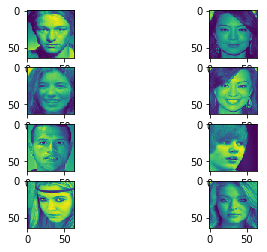

Shape of Left:  (4, 64, 64, 1)
Shape of Right:  (4, 64, 64, 1)
Shape of Label:  (4, 1)


In [19]:
"""
Sanity Checking of our Generated Data
"""


a = FaceDataset()

batch_size = 4

ls, rs, xs = a.get_siamese_batch(batch_size)

f, axarr = plt.subplots(batch_size, 2)

for idx, (l,r,x) in enumerate(zip(ls,rs,xs)):

    print('Row:', idx, '\tLabel:', 'Similar' if x else 'Dissimilar')

    print('Max: ', np.squeeze(l, axis = 2).max())

    #print('Max: ', l.max())
    
    axarr[idx,0].imshow(np.squeeze(l, axis=2))
    axarr[idx,1].imshow(np.squeeze(r, axis=2))
    
    
    #axarr[idx,0].imshow(l)
    #axarr[idx,1].imshow(r)

plt.show()

print('Shape of Left: ', ls.shape)
print('Shape of Right: ', rs.shape)
print('Shape of Label: ', xs.shape)


In [12]:
#Sanity Check with OpenCV

data = FaceDataset()

ls, rs, xs = data.get_siamese_batch(8)

print(ls[0].shape)

#De-normalizing for sanity check display
ls = ls[0] * 255
rs = rs[0] * 255

#cv2.imshow('Left',np.squeeze(ls[2], axis=2))
cv2.imshow('Left' ,ls)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imshow('Right', rs)
cv2.waitKey(0)
cv2.destroyAllWindows()

print('Similarity Flag: ', xs[0])
print('Batch Similarity Shape: ', xs.shape)

====Loading Face Recognition Dataset====
Data Formation Done

Data Shape:  (921, 64, 64, 1)
Labels:  (921,)


(64, 64, 1)
Similarity Flag:  [1]
Batch Similarity Shape:  (8, 1)


In [15]:
#Shape Checking Code (Crap Code)

data = FaceDataset()

print(data.x_train.shape)

placeholder_shape = [None] + list(data.x_train.shape[1:])
print(placeholder_shape)

label = tf.placeholder(tf.int32, [None, 1], name='label')
label_float = tf.to_float(label)

print(label_float.shape)

====Loading Face Recognition Dataset====
Data Formation Done

Data Shape:  (921, 64, 64, 1)
Labels:  (921,)


(921, 64, 64, 1)
[None, 64, 64, 1]
(?, 1)


In [ ]:
batch_size = 16
epochs = 2000

#For Making Checkpoints
step = 100
margin = 0.3


model = lrf_net

dataset = FaceDataset()

#placeholder_shape = [None] + list(dataset.x_train.shape[1:])
#print('Placeholder_Shape: ', placeholder_shape)

#Converting Data To List Format
placeholder_shape = [None] + list(np.squeeze(dataset.x_train.shape[1:], axis=2))

next_batch = dataset.get_siamese_batch

left = tf.placeholder(tf.float32, placeholder_shape, name='left')
right = tf.placeholder(tf.float32, placeholder_shape, name='right')


#1 for Similar, 0 for non-similar
label = tf.placeholder(tf.int32, [None, 1], name='label')
label_float = tf.to_float(label)
    
left_out = model(left, reuse = False)
right_out = model(right, reuse = True)

#loss = contrasive_loss(left_out, right_out, label_float, margin)
loss = max_margin_hinge_loss(left_out, right_out, label_float, margin)


"""
global_step:          Number of Batches seen by Tensorflow Graph
exponential_decay:    For Reducing Learning Rate as Training Proceeds

"""
#Setting Up Optimizer
global_step = tf.Variable(0, trainable = False)
starter_learning_rate = 0.001
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 1000, 0.96, staircase= True)

tf.summary.scalar('lr', learning_rate)

train_step = tf.train.MomentumOptimizer(0.01, 0.99, use_nesterov = True).minimize(loss, global_step = global_step)

#Training

saver = tf.train.Saver()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    
    #Tensorboard Setup
    tf.summary.scalar('step', global_step)
    tf.summary.scalar('loss', loss)
    
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)
        
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('train.log', sess.graph)
    
    
    #Defining an Iteration
    for i in range(epochs):
        
        batch_left, batch_right, batch_similarity = next_batch(batch_size)
        
        _, l, summary_str = sess.run([train_step, loss, merged], 
                                     feed_dict = {left:batch_left, right:batch_right, label: batch_similarity})
        
        print('\r#%d - Loss'%i, l)
        
        #Testing after every 100 iterations
        if(i+1) % step == 0:
            
            #Generate Test
            features = sess.run(left_out, feed_dict = {left: dataset.x_test})
            
            labels = dataset.y_test
            
            #Plotting Results
            f = plt.figure(fig_size = (16,9))
            f.set_tight_layout(True)
            
            for j in range(10):
                
                plt.plot(features[labels==j, 0].flatten, features[labels == j, 1].flatten())
            
            plt.legend(['0','1','2','3','4','5','6','7','8','9','10','11','12'])
            
            plt.savefig('img/%d.jpg' %(i+1))
            
    
    saver.save(sess, 'model/model.ckpt')

====Loading Face Recognition Dataset====
Data Formation Done

Data Shape:  (921, 64, 64, 1)
Labels:  (921,)




In [20]:
print(placeholder_shape)

[None, 32, 32, 1, 3]
